## Hospital medical charges

Imagine that a hospital has hired you as their data analyst. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. This mini-project, as well as the bootstrap and Bayesian inference mini-projects also found in this unit are designed to illustrate how each of the inferential statistics methods have their uses for different use cases. In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?
Answering that last question with a frequentist approach makes some assumptions, or requires some knowledge, about the two groups. In the next mini-project, you'll use bootstrapping to test that assumption. And in the final mini-project of the unit, you're going to create a model for simulating _individual_ charges (not a sampling distribution) that the hospital can use to model a range of scenarios.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). For the purposes of this exercise, assume the observations are the result of random sampling from our one hospital.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind, ttest_1samp
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')
import seaborn as sns

In [9]:
medical.shape

(1338, 8)

In [10]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ The data skew heavily to the right thanks to a relatively small number of varied high values, which impact the mean noticably: while the data's median is around $9,000, then mean is several thousand dollars higher. Because there are so many different values much higher than the mean, the variance (average squared distance from the mean) and therefore the standard deviation are relatively large.

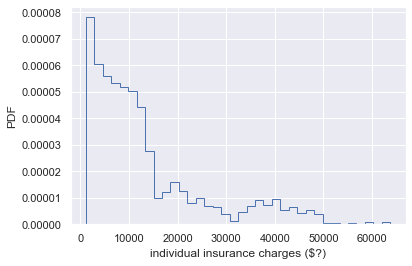

mean of charges: 13270.422265141257
standard deviation of charges: 12105.484975561612


In [12]:
sns.set()
charges = medical['charges']
plt.hist(charges, bins=int(np.sqrt(len(charges))), density=True, histtype='step')
plt.xlabel('individual insurance charges ($?)')
plt.ylabel('PDF')
plt.show()

sample_mean = np.mean(charges)
sample_std = np.std(charges)

print('mean of charges:', sample_mean)
print('standard deviation of charges:', sample_std)

__2:__ The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed above, to apply?

__A:__ A t test to estimate the population mean from the given sample would be appropriate. Even though the data skew far to the right, the sample size is relatively large, and a t distribution approximates a normal distribution more and more closely as degrees of freedom (sample size) increases. The conventional lower bound for a relatively normal t distribution is a sample size of around 30, and this sample is considerably larger than that. 

To be precise about how useful the approximation is, we should construct a confidence interval below and up to the sample's mean, using the sample's standard deviation as an estimate of the whole population's.

__3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned.

__A:__ Because the administrator is only concerned about the value being less than expected, this is a one-sided interval (a one-tailed test).

The critical value of t will correspond in a one-tailed test to a value 5% into the probability density function of the t distribution:

In [15]:
tee = t.ppf(.05, len(charges)-1)
tee

-1.6459941145571324

To construct the one-sided confidence interval, we subtract the margin of error from the sample mean. The margin of error is equal to the critical value t, multiplied by the sample's standard error, which stands in for population standard deviaton as its estimate and is equal to the square root of the sample's variance divided by its sample size:

\begin{equation}
\bar x + t * \frac{\sigma_{\bar x}}{\sqrt{n}}
\end{equation}

In [16]:
margin_of_error = tee * (sample_std/np.sqrt(len(charges)))
margin_of_error
lower_interval_bound = sample_mean + margin_of_error # addition because critical value tee is negative
lower_interval_bound

12725.690859802162

We can say with 95% confidence that the true value of the population mean lies between \\$12,726 and \\$13,270:

\begin{equation}
\$12,726 \le \mu_x \le \$13,270
\end{equation}

Because the lower boundary of this confidence interval is above $12,000, **the administrator should not be concerned**.

But in fact, we can do better than this: the critical value $t$ for a confidence interval of 99.9\% is 3.06, which still leaves the whole interval a couple hundred dollars above \\$12,000. If we were to repeatedly take samples of this size from the population, we can say with 99.9% percent confidence that the sample mean would be above $12,000:

In [21]:
tee = t.ppf(.001, len(charges)-1)
tee

-3.0963391709032937

In [22]:
margin_of_error = tee * (sample_std/np.sqrt(len(charges)))
margin_of_error
lower_interval_bound = sample_mean + margin_of_error
lower_interval_bound

12245.708280409635

We can say with 99.9% confidence that

\begin{equation}
\$12,245 \le \mu_x \le \$13,270
\end{equation}

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means where the pooled standard deviation of the two groups is given by
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t* test statistic is then given by

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

What assumption, or assumptions, are we making here?

__A:__ 
The null hypothesis, $H_0: \mu_1 = \mu_2$ (The mean hospital charge for people with insurance equals the mean hospital charge for people without insurance.)

The alternative hypothesis, $H_a: \mu_1 \ne \mu_2$ (The mean hospital charge for people with insurance doesn't equal the mean hospital charge for people without insurance.)

We're making three assumptions. Because we're sampling without replacement, one is that both of these groups are independent samples, which means that each group's size must be less than 10 percent of the total population. This [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance) technique also assumes that the two samples have the same variance. To perform a significance test, we should also assume a significance level; we'll assume the common value $\alpha = 0.05$. If the p value that results from our test is below this value, we'll reject the null hypothesis; if the p value that results from our test is above this value, we'll fail to reject the null hypothesis.

__5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ First we separate out the two groups into two samples.

In [23]:
insured = medical[medical['insuranceclaim'] == 1]
uninsured = medical[medical['insuranceclaim'] == 0]

Next, we get the two groups' charges as two series.

In [24]:
insured_charges = insured['charges']
uninsured_charges = uninsured['charges']

Next we calculate the pooled standard deviation of the two samples:

\begin{equation}
\sigma_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

In [25]:
s_0 = np.std(insured_charges)
s_1 = np.std(uninsured_charges)

numerator = (len(insured) - 1) * s_0**2 + (len(uninsured) - 1) * s_1**2
denominator = len(insured) + len(uninsured) - 2

std_pooled = np.sqrt(numerator/denominator)
std_pooled

11512.282899205748

$\sigma_p = \$11,512.28$

And we can calculate the test statistic $t$:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{\sigma_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}


In [27]:
means_difference = np.mean(insured_charges) - np.mean(uninsured_charges)
square_root_of_sum_of_sample_size_recpirocals = np.sqrt(1/len(insured) + 1/len(uninsured))

tee = means_difference/ (std_pooled * square_root_of_sum_of_sample_size_recpirocals)
tee

11.901306943555388

This value is much, much higher than 1.96, which would be the t value for the ends of our 95% confidence interval. Since it's very unlikely for us to get this value assuming the means are equal, we should reject the null hypothesis and seriously consider the possibility that insured and uninsured patients are being charge different average amounts.

And now we perform the same calculation using `scipy.stats.ttest_ind`, which shows an all-but-identical value for $t$ and a very, very low p value:

In [28]:
ttest_ind(uninsured_charges, insured_charges)

Ttest_indResult(statistic=-11.893299030876712, pvalue=4.461230231620717e-31)

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and that is much easier to use. All you need to do is pass it your data.

__6:__ In the above calculations, we assumed the sample variances were equal. We may well suspect they are not (we'll explore this in another assignment). The calculation becomes a little more complicated to do by hand in this case, but we now know of a helpful function. Check the documentation for the function to tell it not to assume equal variances and perform the test again.

__A:__

In [29]:
ttest_ind(uninsured_charges, insured_charges, equal_var=False) # without assuming the same variance in both samples

Ttest_indResult(statistic=-13.298031957975649, pvalue=1.1105103216309125e-37)

__7:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__

In [30]:
ttest_1samp(charges, 12000)

Ttest_1sampResult(statistic=3.8373517196585314, pvalue=0.000130171652092872)

We constructed a one-tailed 95% confidence interval below the sample mean to show that's very unlikely the true mean is below \\$12,000. The very low p-value here shows that we would reject a null hypothesis that the true mean is \\$12,000, even with a very strict significance threshold.